<h>Importo las librerias para graficar, hacer ETL y EDA<h>

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

<h>Cargo el dataset a un DataFrame y creo la columna con el valor objetivo<h>

In [201]:

df = pd.read_csv('hospitalizaciones_train.csv')
df['Stay'] = 0
df.loc[df['Stay (in days)'] > 8, 'Stay'] = 1

<h>Realizo una exploracion del Datasets<h>

In [158]:
df.head(1)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days),Stay
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8,0


<h>Vemos si existen valores nulos.<h>
<h>Pero podemos apreciar que tienen todos los datos, o que los valores nulos estan representados de otra forma<h>

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

<h>Como vemos la mayoria de columnas son del tipo de dato cualitativo, pasamos a ver que hay en cada columna<h>


<h>Vemos que en la columna generos hay una variable 'Other', con un bajo porcentaje de aparicion en base a la cantidad de
datos totales. Pero como puede aportar informacion importante para el modelo lo dejamos<h>

In [162]:
df['gender'].value_counts()

None                   137202
Other                   78335
High Blood Pressure     64089
Diabetes                58689
Asthama                 50428
Heart disease           21257
Name: health_conditions, dtype: int64

<h>health_conditions: Condiciones de salud del paciente. Tambien dejamos las variables intactas. Por que pueden ingresar sin ninguna condicion de salud anterior pero de igual forma tener una estadia larga<h>

In [163]:
df['health_conditions'].value_counts()

None                   137202
Other                   78335
High Blood Pressure     64089
Diabetes                58689
Asthama                 50428
Heart disease           21257
Name: health_conditions, dtype: int64

<h>Codificamos todas las variables con LabelEncoder para no separar los diferentas datos de cada columna. Eliminamos las columnas patientid, Stay (in days), Insurance y Visitors with Patient. Que estamos seguros que no le va a aportar informacion relevante al modelo por que no tiene relacion con la salud del paciente<h>

In [4]:
le = preprocessing.LabelEncoder()

In [200]:
def ETL(df):
    df['Department'] = le.fit_transform(df['Department'])
    df['Ward_Facility_Code'] = le.fit_transform(df['Ward_Facility_Code'])
    df['doctor_name'] = le.fit_transform(df['doctor_name'])
    df['Age'] = le.fit_transform(df['Age'])
    df['gender'] = le.fit_transform(df['gender'])
    df['Type of Admission'] = le.fit_transform(df['Type of Admission'])
    df['Severity of Illness'] = le.fit_transform(df['Severity of Illness'])
    df['health_conditions'] = le.fit_transform(df['health_conditions'])

    df.drop(columns=['patientid', 'Insurance', 'Visitors with Patient', 'Admission_Deposit'], inplace=True)
    return df

In [202]:
df = ETL(df)
df.drop(columns=['Stay (in days)'], inplace=True)

In [192]:
df.head(1)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions,Stay
0,4,2,3,8,0,4,0,1,0,1,0


<h>Creamos una funcion para graficar un heatmap y ver la correlacions de las variable, con la variable objetivo<h>

In [169]:
def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(20,20))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show()

<h>Podemos apreciar que las variables mas correlacionadas son: Department, doctor_name, Age, gender. Esas son los features que vamos a usar para el modelado, exepto doctor_name ya que en los hospitales cada sector tiene doctores fijos por lo que podemos decir que son lo mismo.<h>

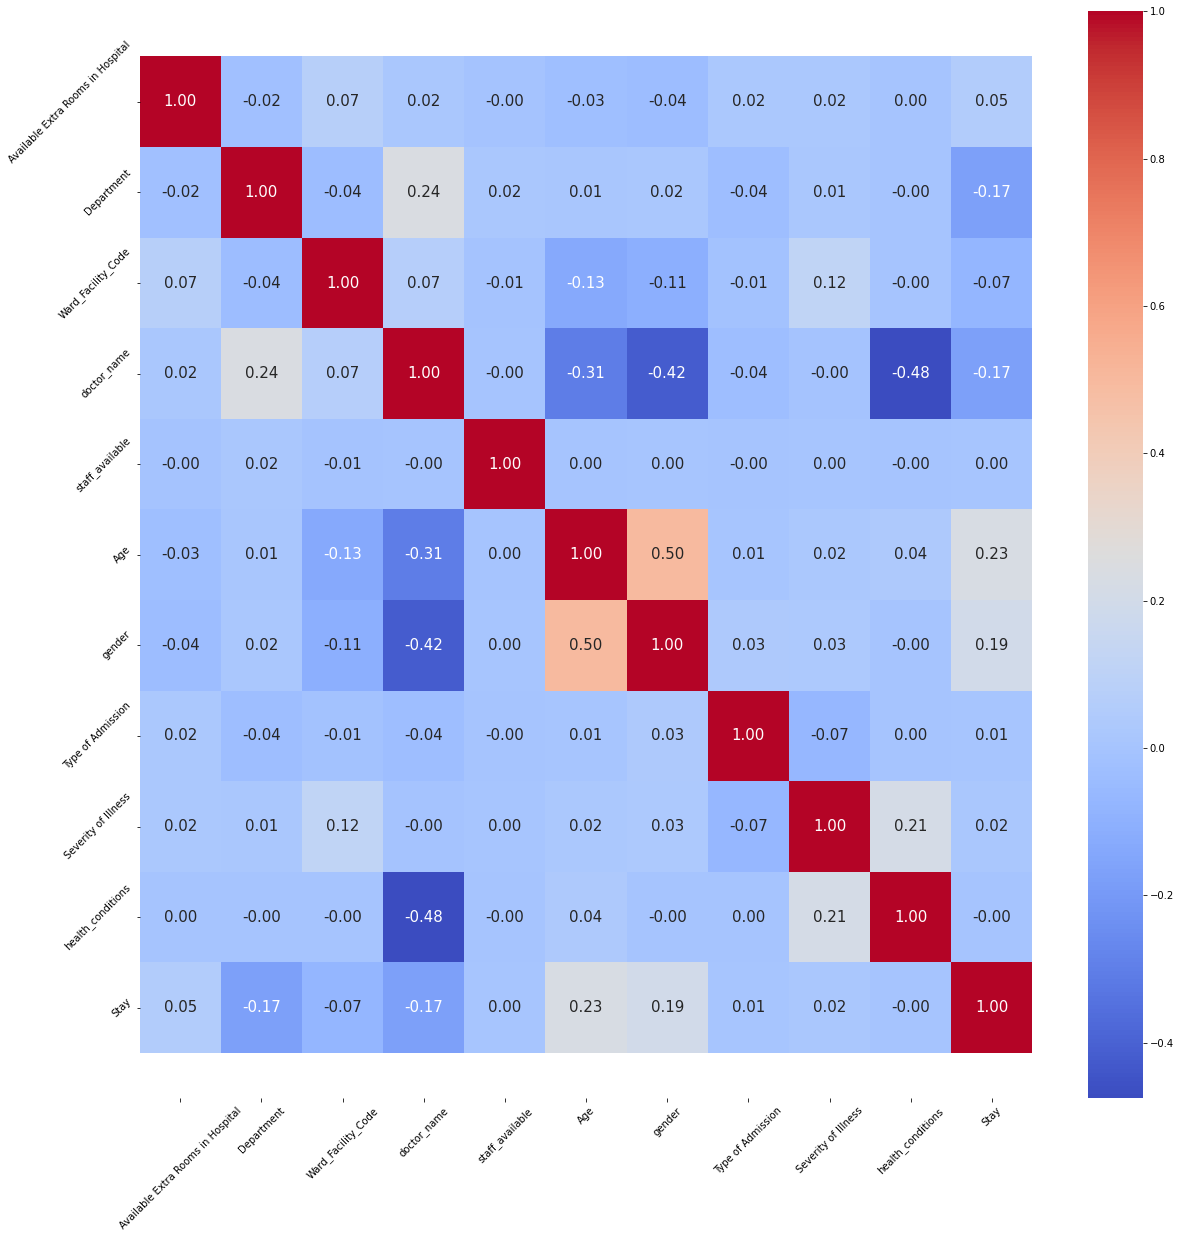

In [170]:
corr = df.corr()
plot_corre_heatmap(corr)

<h>Importamos nuestro modelo, separamos las variables X y y del modelado<h>

In [177]:
from sklearn.tree import DecisionTreeClassifier

# Creamos un objeto arbol
tree = DecisionTreeClassifier()

In [203]:
#X = df[['anesthesia','gynecology', 'female', 'Age', 'male']]
X = df[['gender', 'Department', 'Age']]
y = df['Stay']

<h> Separamos el datasets en train y set. Una para el modelado y la otra para probarlo y medir las metricas<h>

In [204]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [205]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [206]:
from sklearn.metrics import accuracy_score

# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.6875136512559156
Accuracy sobre conjunto de Test: 0.687819660014782


In [207]:
from sklearn.metrics import recall_score
recall_score(y_train, y_train_pred, average='macro')

0.5856342923344275

<h>Una vez entrenado el modelo, medir las metricas. Pasamos a predecir sobre el Dataset test. Pero antes que eso aplicamos las transformaciones requeridas<h>

In [196]:
df_test = pd.read_csv('hospitalizaciones_test.csv')
df_test.head(1)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit
0,3,gynecology,F,Dr Olivia,10,2858,21-30,Female,Trauma,Moderate,Other,2,No,4749.640225


In [208]:
df_test = ETL(df_test)

In [209]:
df_test.head(1)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions
0,3,2,5,4,10,2,0,1,2,5


In [210]:
tree.fit(X, y)

DecisionTreeClassifier()

In [211]:
y_pred = tree.predict(X)

<h>Guardamos la prediccion en un csv<h>

In [214]:
y_pred = pd.DataFrame(y_pred)

In [217]:
y_pred.rename(columns={0 : 'pred'}, inplace=True)

In [218]:
y_pred.to_csv('SebastianArrua.csv', index=False)